In [128]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [129]:
df = pd.read_csv("data/statcast_pitch_swing_data_20240402_20241030_with_arm_angle.csv")
df = df.dropna(subset=['bat_speed', 'swing_length'])
df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
3628,FS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,2.0,3.10,1.15,1.15,31.8
3631,FF,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,3,2,6.0,1.0,6.0,2.0,1.45,1.26,1.26,23.2
3633,CU,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,4.0,4.08,-0.89,-0.89,43.8
3636,FS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,3,2,6.0,1.0,6.0,2.0,3.05,1.27,1.27,29.9
3637,FC,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,3,2,6.0,1.0,6.0,4.0,1.44,0.15,0.15,38.3


In [130]:
df.shape

(322556, 113)

In [131]:
df['pitch_type'].unique()

array(['FS', 'FF', 'CU', 'FC', 'SL', 'CH', 'SI', 'FO', 'ST', 'KC', 'SV',
       'FA', 'KN', 'EP', nan, 'SC', 'CS'], dtype=object)

In [132]:
df_test = df.copy()

In [133]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322556 entries, 3628 to 701555
Columns: 113 entries, pitch_type to arm_angle
dtypes: float64(62), int64(34), object(17)
memory usage: 280.5+ MB


In [134]:
df_test['on_3b'] = df_test['on_3b'].notna().astype(int)
df_test['on_2b'] = df_test['on_2b'].notna().astype(int)
df_test['on_1b'] = df_test['on_1b'].notna().astype(int)

In [135]:
player_avg_data = df.groupby('player_name').agg(
    avg_swing_length=('swing_length', 'mean'),
    avg_bat_speed=('bat_speed', 'mean'),
    min_bat_speed=('bat_speed', 'min'),
    max_bat_speed=('bat_speed', 'max'),
    min_swing_length=('swing_length', 'min'),
    max_swing_length=('swing_length', 'max'),
    std_swing_length=('swing_length', 'std'),
    std_bat_speed=('bat_speed', 'std')
).reset_index()

In [136]:
df_with_averages = df_test.merge(player_avg_data, on='player_name', how='left')
df_with_averages.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'api_break_x_batter_in', 'arm_angle', 'avg_swing_length',
       'avg_bat_speed', 'min_bat_speed', 'max_bat_speed', 'min_swing_length',
       'max_swing_length', 'std_swing_length', 'std_bat_speed'],
      dtype='object', length=121)

In [137]:
# Calculate the difference to determine if above or below the player average
df_with_averages['bat_speed_zscore'] = (df_with_averages['bat_speed'] - df_with_averages['avg_bat_speed']) / df_with_averages['std_bat_speed']
df_with_averages['swing_length_zscore'] = (df_with_averages['swing_length'] - df_with_averages['avg_swing_length']) / df_with_averages['std_swing_length'] 

In [138]:
df_count = df_with_averages[['balls', 'strikes', 'bat_speed_zscore']]

df1 = df_count.groupby(['balls', 'strikes']).agg(
    avgz = ('bat_speed_zscore', 'mean')
).reset_index()

df1 = df1[(df1['balls'] <= 3) & (df1['strikes'] <= 2)]

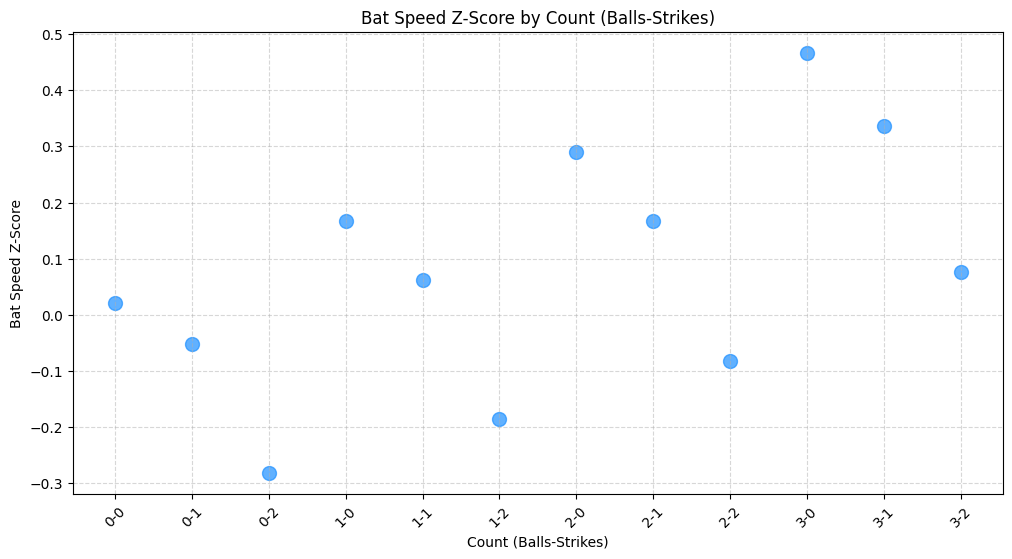

In [139]:
# Create the 'count' column
df1['count'] = df1['balls'].astype(str) + '-' + df1['strikes'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df1['count'], df1['avgz'], color='dodgerblue', s=100, alpha=0.7)
plt.xlabel('Count (Balls-Strikes)')
plt.ylabel('Bat Speed Z-Score')
plt.title('Bat Speed Z-Score by Count (Balls-Strikes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [140]:
df_count = df_with_averages[['balls', 'strikes', 'swing_length_zscore']]

df1 = df_count.groupby(['balls', 'strikes']).agg(
    avgz = ('swing_length_zscore', 'mean')
).reset_index()

df1 = df1[(df1['balls'] <= 3) & (df1['strikes'] <= 2)]

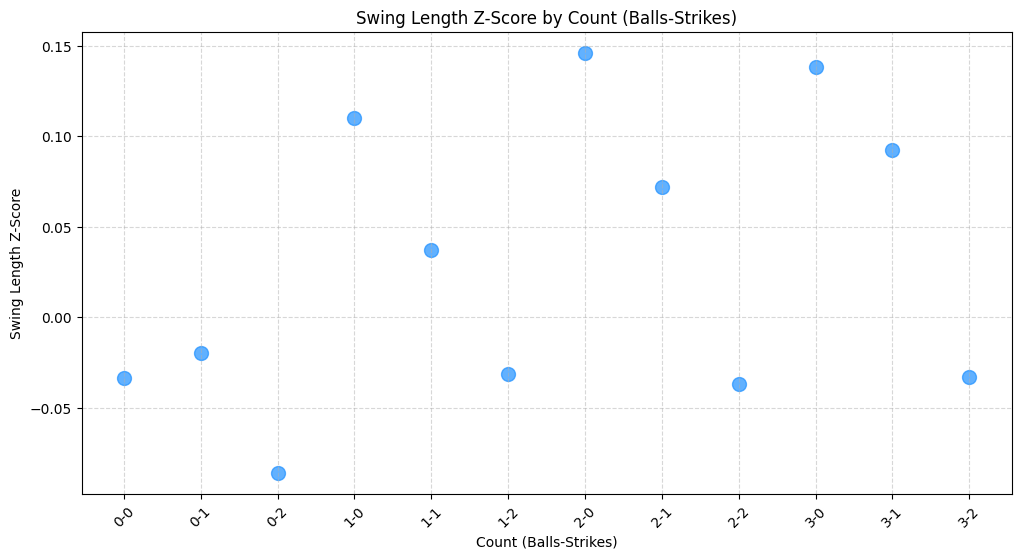

In [141]:
# Create the 'count' column
df1['count'] = df1['balls'].astype(str) + '-' + df1['strikes'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df1['count'], df1['avgz'], color='dodgerblue', s=100, alpha=0.7)
plt.xlabel('Count (Balls-Strikes)')
plt.ylabel('Swing Length Z-Score')
plt.title('Swing Length Z-Score by Count (Balls-Strikes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [142]:
pitch_type_map = {
    "CH": "OS",  # Off-Speed
    "CU": "BB",  # Breaking Ball
    "FC": "FB",  # Fastball
    "EP": "BB",  # Breaking Ball
    "FO": "OS",  # Off-Speed
    "FF": "FB",  # Fastball
    "KN": "OS",  # Off-Speed
    "KC": "BB",  # Breaking Ball
    "SC": "OS",  # Off-Speed
    "SI": "FB",  # Fastball
    "SL": "BB",  # Breaking Ball
    "SV": "BB",  # Breaking Ball
    "FS": "OS",  # Off-Speed
    "ST": "BB"   # Breaking Ball
}


In [143]:
# for each player see what batspeed above their average
# gives them the best woba value for each pitch category

In [144]:
df_with_categories = df.copy()

df_with_categories['pitch_type'] = df['pitch_type'].map(pitch_type_map)

df_with_categories.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
3628,OS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,2.0,3.10,1.15,1.15,31.8
3631,FB,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,3,2,6.0,1.0,6.0,2.0,1.45,1.26,1.26,23.2
3633,BB,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,4.0,4.08,-0.89,-0.89,43.8
3636,OS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,3,2,6.0,1.0,6.0,2.0,3.05,1.27,1.27,29.9
3637,FB,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,3,2,6.0,1.0,6.0,4.0,1.44,0.15,0.15,38.3


In [145]:
df_with_averages['pitch_type'] = df_with_averages['pitch_type'].map(pitch_type_map)

df_with_averages.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,avg_swing_length,avg_bat_speed,min_bat_speed,max_bat_speed,min_swing_length,max_swing_length,std_swing_length,std_bat_speed,bat_speed_zscore,swing_length_zscore
0,OS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,7.155963,69.909633,34.1,85.0,4.1,9.3,0.963941,7.523636,0.982287,0.668129
1,FB,2024-04-03,96.7,-2.49,5.03,"Ramírez, Harold",623912,543135,NaN,foul,...,7.155963,69.909633,34.1,85.0,4.1,9.3,0.963941,7.523636,-0.134195,-0.887983
2,BB,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,7.351809,68.274530,4.6,84.6,1.3,9.2,0.991942,9.725634,-2.588472,0.048582
3,OS,2024-04-03,88.2,-2.42,5.41,"Ramírez, Harold",623912,543135,NaN,foul_tip,...,7.155963,69.909633,34.1,85.0,4.1,9.3,0.963941,7.523636,1.274698,0.875610
4,FB,2024-04-03,95.9,-1.12,5.91,"Fermin, Freddy",666023,669203,NaN,foul,...,7.351809,68.274530,4.6,84.6,1.3,9.2,0.991942,9.725634,0.136286,0.048582


In [146]:

df_with_averages['bat_speed_above_average'] = df_with_averages['bat_speed_zscore'] > 0
df_with_averages['bat_speed_below_average'] = df_with_averages['bat_speed_zscore'] < 0

In [147]:

# Group by player_name and pitch_type, then calculate the mean wOBA value
average_woba = (
    df_with_averages.groupby(["player_name", "pitch_type", 'bat_speed_above_average'])["woba_value"]
    .mean()
    .reset_index()
    .rename(columns={"woba_value": "avg_woba_value"})
)

# Display the result
average_woba.head(20)


,player_name,pitch_type,bat_speed_above_average,avg_woba_value
0,"Abrams, CJ",BB,False,0.185000
1,"Abrams, CJ",BB,True,0.222685
2,"Abrams, CJ",FB,False,0.255634
3,"Abrams, CJ",FB,True,0.480195
4,"Abrams, CJ",OS,False,0.103846
5,"Abrams, CJ",OS,True,0.221094
6,"Abreu, José",BB,False,0.000000
7,"Abreu, José",BB,True,0.244118
8,"Abreu, José",FB,False,0.313333
9,"Abreu, José",FB,True,0.117391


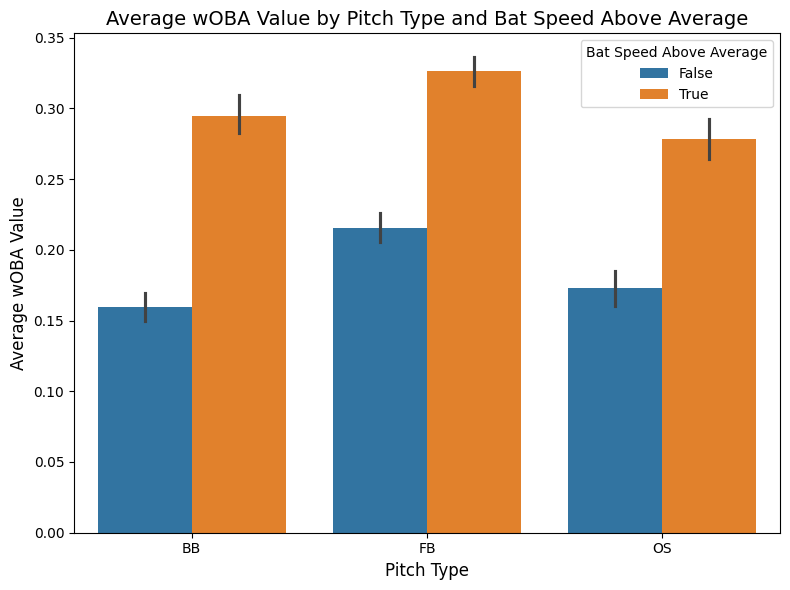

In [148]:
import seaborn as sns

plt.figure(figsize=(8, 6))

# Plot with seaborn to group by 'bat_speed_above_average'
sns.barplot(
    data=average_woba,
    x="pitch_type",
    y="avg_woba_value",
    hue="bat_speed_above_average"
)

# Add labels and title
plt.title("Average wOBA Value by Pitch Type and Bat Speed Above Average", fontsize=14)
plt.xlabel("Pitch Type", fontsize=12)
plt.ylabel("Average wOBA Value", fontsize=12)
plt.legend(title="Bat Speed Above Average")
plt.tight_layout()

# Show the plot
plt.show()

In [149]:

df_with_averages['swing_length_above_average'] = df_with_averages['swing_length_zscore'] > 0
df_with_averages['swing_length_below_average'] = df_with_averages['swing_length_zscore'] < 0

In [150]:
# Group by player_name and pitch_type, then calculate the mean wOBA value
average_woba = (
    df_with_averages.groupby(["player_name", "pitch_type", 'swing_length_above_average'])["woba_value"]
    .mean()
    .reset_index()
    .rename(columns={"woba_value": "avg_woba_value"})
)

# Display the result
average_woba.head()


,player_name,pitch_type,swing_length_above_average,avg_woba_value
0,"Abrams, CJ",BB,False,0.160000
1,"Abrams, CJ",BB,True,0.224060
2,"Abrams, CJ",FB,False,0.379577
3,"Abrams, CJ",FB,True,0.460241
4,"Abrams, CJ",OS,False,0.128571


In [151]:
df['pitch_type'] = df['pitch_type'].map(pitch_type_map)

In [152]:
df.dropna(subset=['bat_speed','swing_length', 'pitch_type','woba_value'])

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
3628,OS,2024-04-03,90.1,-2.36,5.30,"Ramírez, Harold",623912,543135,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,2.0,3.10,1.15,1.15,31.8
3633,BB,2024-04-03,83.6,-0.87,6.10,"Fermin, Freddy",666023,669203,strikeout,swinging_strike,...,3,2,6.0,1.0,6.0,4.0,4.08,-0.89,-0.89,43.8
3643,OS,2024-04-03,81.7,-1.48,5.75,"Guerrero Jr., Vladimir",665489,664299,strikeout,swinging_strike,...,3,2,5.0,1.0,6.0,2.0,2.82,0.97,0.97,37.5
3645,BB,2024-04-03,77.6,-2.23,5.51,"Palacios, Richie",680700,543135,strikeout,swinging_strike,...,3,2,6.0,2.0,6.0,3.0,4.63,-0.51,0.51,35.0
3677,OS,2024-04-03,82.5,0.76,5.92,"Profar, Jurickson",595777,668868,field_out,hit_into_play,...,3,2,5.0,1.0,7.0,2.0,3.19,0.94,-0.94,54.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701513,BB,2024-10-30,86.0,-2.33,5.43,"Torres, Gleyber",650402,656427,field_out,hit_into_play,...,1,0,5.0,1.0,NaN,NaN,2.83,-0.53,-0.53,28.1
701523,FB,2024-10-30,94.0,0.06,5.99,"Stanton, Giancarlo",519317,681911,field_out,hit_into_play,...,1,2,2.0,1.0,NaN,NaN,0.83,0.74,-0.74,61.1
701524,OS,2024-10-30,88.3,-2.49,5.53,"Hernández, Enrique",571771,592454,single,hit_into_play,...,1,3,2.0,1.0,NaN,NaN,2.64,1.00,1.00,30.4
701544,FB,2024-10-30,95.5,-1.78,5.85,"Stanton, Giancarlo",519317,518489,home_run,hit_into_play,...,1,1,2.0,1.0,NaN,NaN,1.24,0.58,0.58,39.0


In [153]:
df_with_averages['woba_value'].isnull().sum()


np.int64(176887)

In [154]:
dfplot = df_with_averages.dropna(subset= ['woba_value'])

import plotly.express as px
fig = px.scatter(dfplot, x="swing_length", y="bat_speed", color="pitch_type", size='woba_value')

fig.update_layout(autosize=True) # remove height=800
fig.show(renderer="browser") 


In [155]:
import plotly.graph_objects as go

fig = go.Figure()

for player in dfplot['player_name'].unique():
    player_data = dfplot[dfplot['player_name'] == player]
    fig.add_trace(
        go.Scatter3d(
            x=player_data['swing_length'],
            y=player_data['bat_speed'],
            z=player_data['woba_value'],
            mode='markers',
            marker=dict(size=5),
            name=player,
            visible=True  # Start with all players visible
        )
    )

# Create dropdown menu
buttons = [
    {
        "label": "All",
        "method": "update",
        "args": [{"visible": [True] * len(dfplot['player_name'].unique())}]
    }
]

buttons += [
    {
        "label": player,
        "method": "update",
        "args": [{"visible": [p == player for p in dfplot['player_name'].unique()]}]
    }
    for player in dfplot['player_name'].unique()
]

# Add dropdown menu to layout
fig.update_layout(
    updatemenus=[
        {
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
        }
    ],
    # Add axis labels
    scene=dict(
        xaxis_title='Swing Length',
        yaxis_title='Bat Speed',
        zaxis_title='wOBA Value'
    )
)

#fig.show()
fig.show(renderer="browser") 